### TODO

- ~~Create the AdaIN layer~~
- ~~Create the reverse VGG19 model to have the decoder, and make it trainable~~
- ~~Create a custom model~~
- ~~Create the loss function~~
- Automatically log the model and its hyperparameters on each training using MLFlow
--> Create a complete training pipeline : compile the model, fit it, log it (Add experiment and tags argument in the training function for the logging)
- Create content and style datasets from the loaded images, with automatic image resizing pipeline for the training part (and eventually 256*256 window cropping)
- Add getters and setters when required in AdaINDataModule
- Add verbose steps for the process

In [47]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import mlflow
from mlflow.models import infer_signature
from sklearn.model_selection import train_test_split
from torchvision import transforms

os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras import Loss
from keras.preprocessing import image, image_dataset_from_directory # type: ignore
from pathlib import Path

from adain_model import AdaINModel, instance_mean, instance_std

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..362.7572].


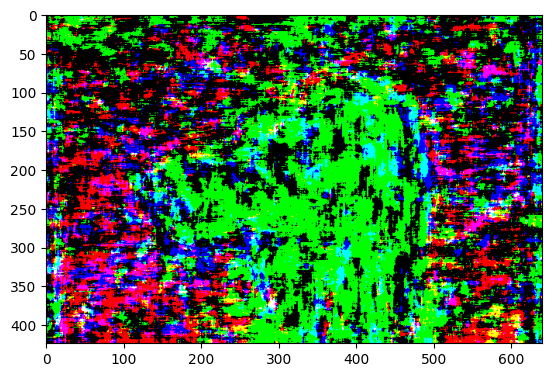

In [6]:
c = torch.Tensor(np.array([keras.utils.img_to_array(image.load_img(Path("D:/StyleTransferAI/StyleTransferAI/datasets/unlabeled2017/unlabeled2017/000000000013.jpg")))])).to('cuda')
s = torch.Tensor(np.array([keras.utils.img_to_array(image.load_img(Path("D:/StyleTransferAI/StyleTransferAI/datasets/WikiArt/Abstract_Expressionism/alice-baber_abstract-composition-1969.jpg")))])).to('cuda')
a = AdaINModel()

plt.imshow(a([c,s]).clone().detach().cpu().numpy()[0])

In [ ]:
# Set our tracking server uri for logging
mlflow.set_tracking_uri(Path("D:/Python/ML Flow/mlruns"))

# Create a new MLflow Experiment
mlflow.set_experiment("Test2")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Debugging run")

    # Infer the model signature
    signature = infer_signature(X_train, model.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="iris_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="tracking-quickstart",
    )

AttributeError: 'generator' object has no attribute 'items'